# Yulu Business Hypothesis Testing

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

### Objectives

Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
How well those variables describe the electric cycle demands?

### Data description

Column Profiling:

datetime: datetime

season: 
        1: spring 
        2: summer
        3: fall 
        4: winter

holiday: whether day is a holiday or not
        1: yes
        0: no

workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
        1: weekday (not including holiday)
        0: weekend

weather: 
        1: Clear, Few clouds, partly cloudy 
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: temperature in Celsius

atemp: real feel temperature in Celsius

humidity: humidity

windspeed: wind speed

casual: count of casual users

registered: count of registered users

count: count of total rental bikes including both casual and registered

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pingouin as pg

from scipy.stats import shapiro, anderson, normaltest
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import warnings 
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (16,12)

In [5]:
# Importing data
df_yulu = pd.read_csv('yulu_bike_sharing_dataset.csv')
df_yulu.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# Data description
df_yulu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
df_yulu.shape

(10886, 12)

In [8]:
# Description of the numeric variables
df_yulu.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [9]:
# Checking fot missing values
df_yulu.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot:>

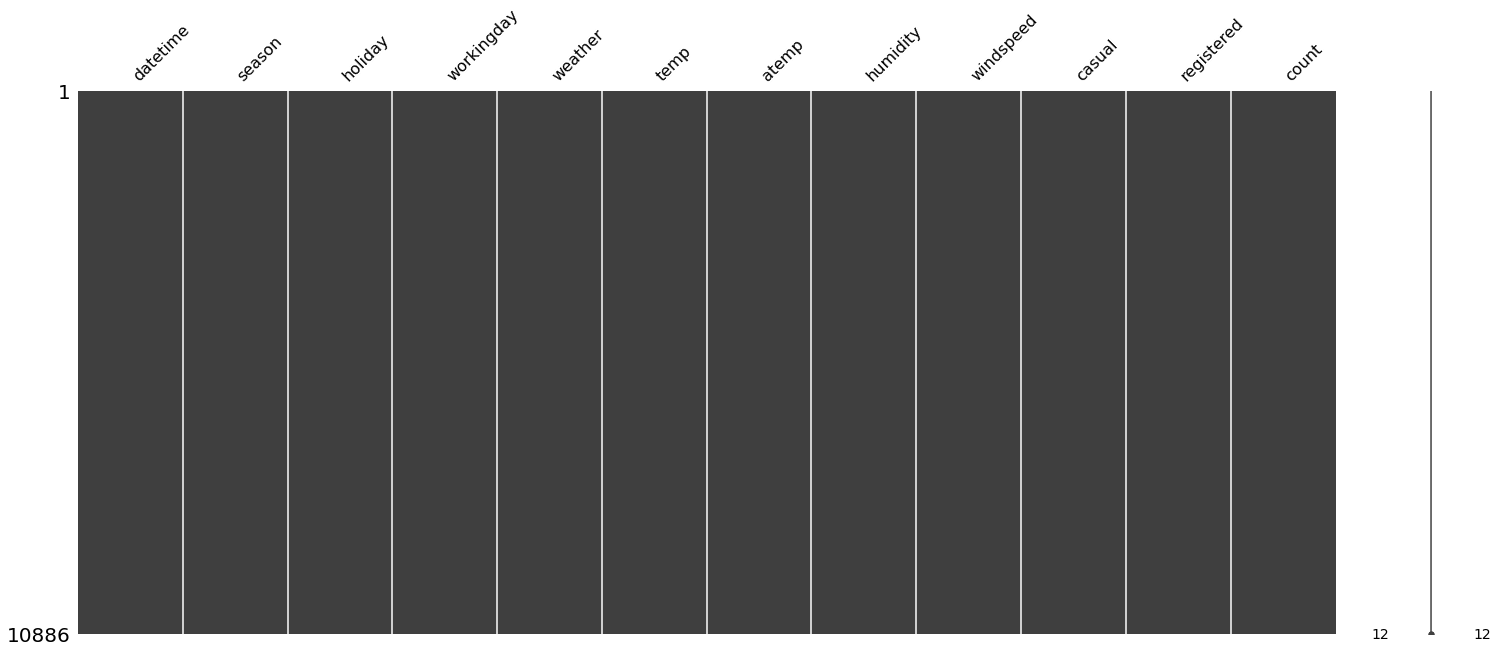

In [10]:
# Missing value detection
msno.matrix(df_yulu)

It seems that the dataset has no missing value.

## EDA

Let's have a look the number of observations by plotting the weather and the season to see some insights.

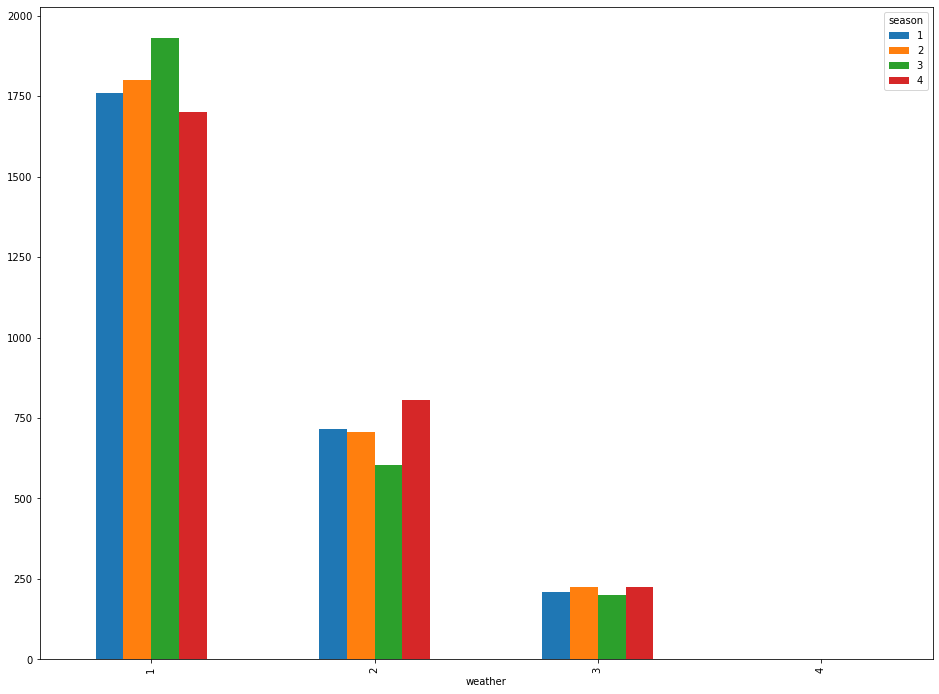

In [100]:
pd.crosstab(df_yulu['weather'], df_yulu['season']).plot(kind = 'bar')
plt.show()

It seems that during the observations most of the time the weather was sunny or partly cloudy.

In [41]:
df_yulu.groupby('weather')['season'].count()

weather
1    7192
2    2834
3     859
4       1
Name: season, dtype: int64

The weather was during the two year period mostly clear, clear with few clouds and possible mist in the early hours during nights 92% of the time.

In [13]:
# The number of customers by weekday and weekend in the two categories
df_yulu.groupby(['workingday'])['casual', 'registered'].sum()

,casual,registered
workingday,,
0,206037,448835
1,186098,1244506


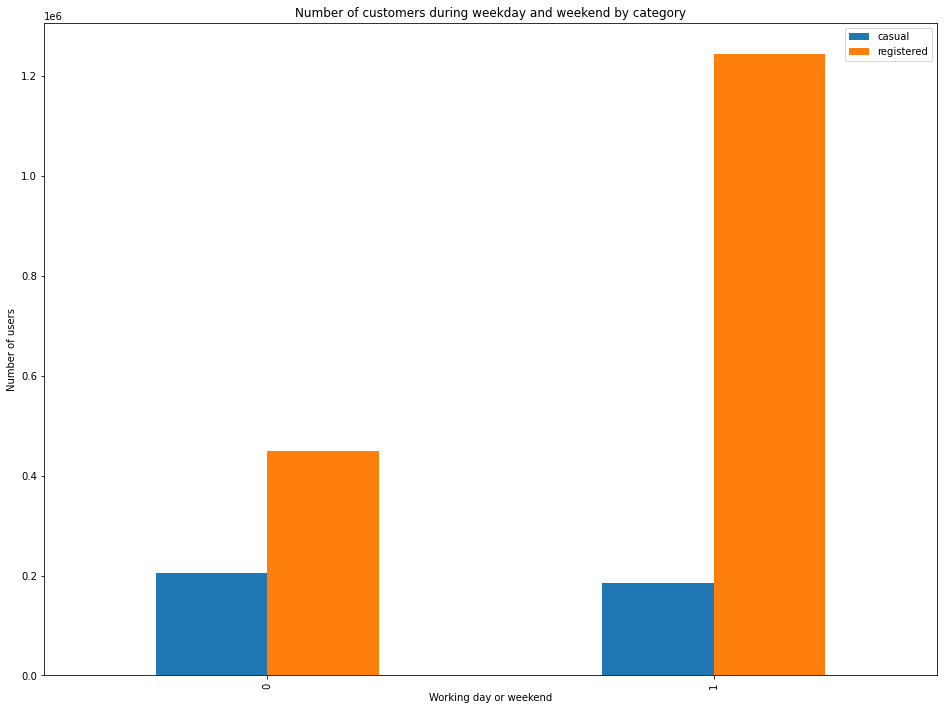

In [93]:
df_yulu.groupby(['workingday'])['casual', 'registered'].sum().plot(kind = 'bar')
plt.title('Number of customers during weekday and weekend by category')
plt.xlabel('Working day or weekend')
plt.ylabel('Number of users')
plt.show()

From this crosstable we can see that there are more registered customer used the service during the week, possibly for work.    
The number os casual users is higher during the weekend and nearly half the registered users, meanwhile during the week the number of users    
who used the service in the observation period is much higher.

In [14]:
df_yulu.groupby(['holiday'])['casual', 'registered'].sum()

,casual,registered
holiday,,
0,376964,1650704
1,15171,42637


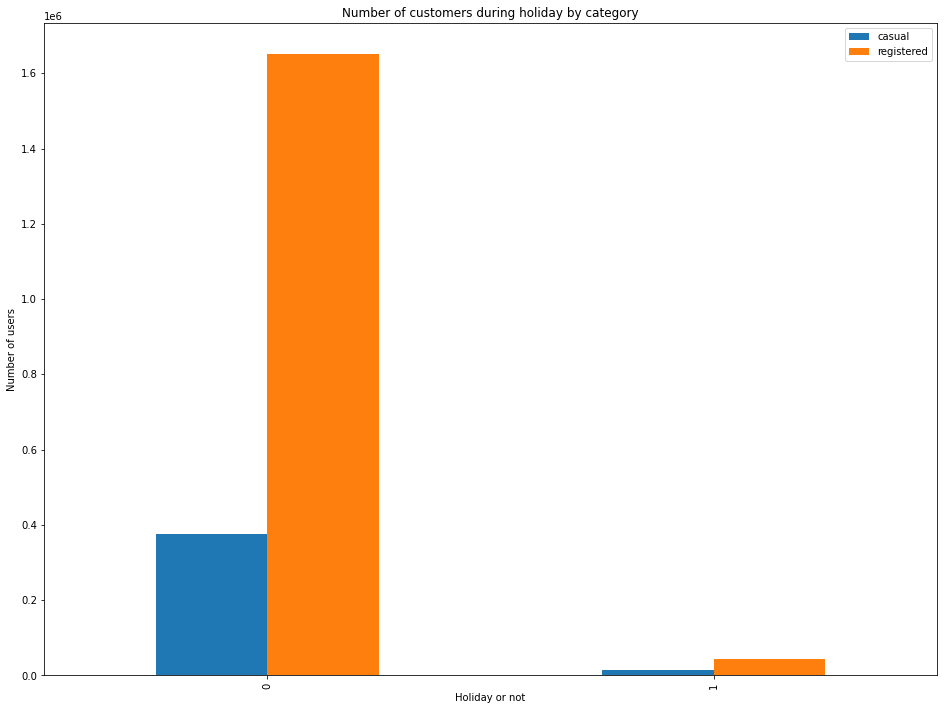

In [94]:
df_yulu.groupby(['holiday'])['casual', 'registered'].sum().plot(kind = 'bar')
plt.title('Number of customers during holiday by category')
plt.xlabel('Holiday or not')
plt.ylabel('Number of users')
plt.show()

This groupping shows that the service was used mostly on non holidays but working days.

In [97]:
pd.crosstab(index = df_yulu['workingday'], columns = df_yulu['weather'])

weather,1,2,3,4
workingday,,,,
0,2353,897,224,0
1,4839,1937,635,1


The weather on holidays versus non holidays.

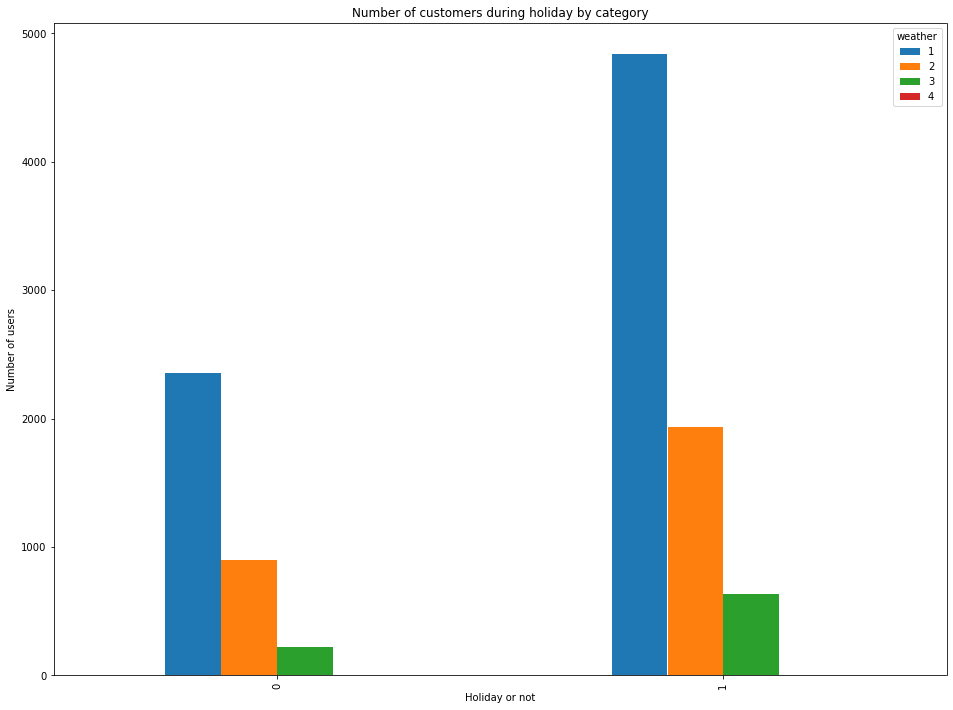

In [96]:
pd.crosstab(index = df_yulu['workingday'], columns = df_yulu['weather']).plot(kind = 'bar')
plt.title('Number of customers during holiday by category')
plt.xlabel('Holiday or not')
plt.ylabel('Number of users')
plt.show()

In [98]:
pd.crosstab(index = df_yulu['holiday'], columns = df_yulu['weather'])

weather,1,2,3,4
holiday,,,,
0,6988,2742,844,1
1,204,92,15,0


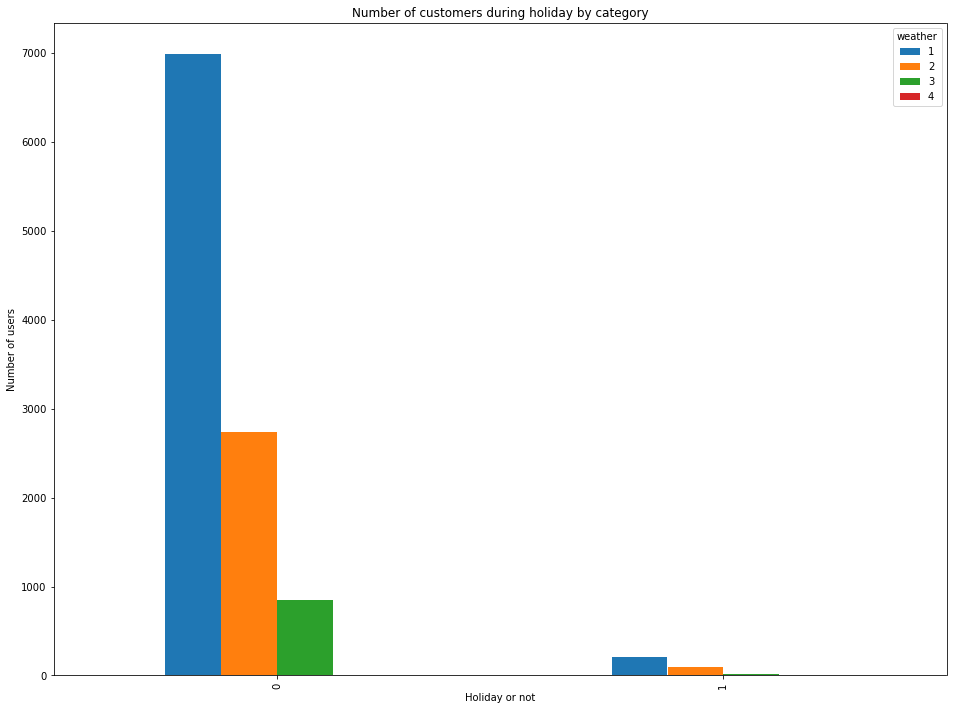

In [99]:
pd.crosstab(index = df_yulu['holiday'], columns = df_yulu['weather']).plot(kind = 'bar')
plt.title('Number of customers during holiday by category')
plt.xlabel('Holiday or not')
plt.ylabel('Number of users')
plt.show()

In [43]:
season_temp_humidity = df_yulu[['datetime', 'temp', 'season', 'humidity', 'windspeed']]
avg_values = season_temp_humidity.groupby('season').mean()
avg_values

,temp,humidity,windspeed
season,,,
1,12.530491,56.297841,14.636978
2,22.823483,60.852909,13.405607
3,28.789111,64.123674,11.508862
4,16.649239,66.173738,11.678147


<AxesSubplot:xlabel='season'>

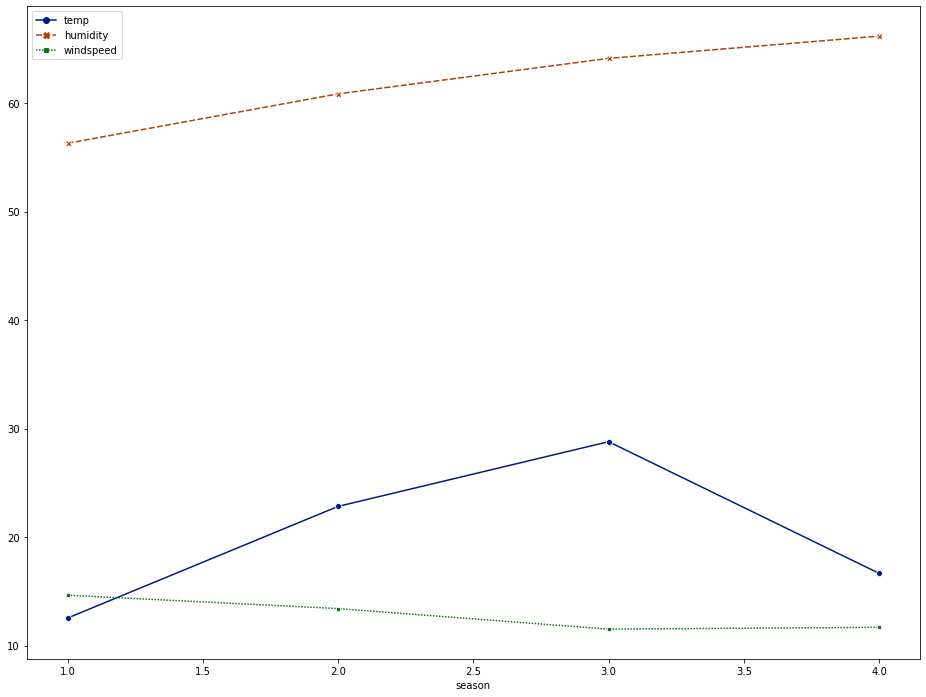

In [45]:
sns.lineplot(data = avg_values, markers = True, palette = 'dark')

The graph shows that during the average observations of temperature, humidity and windspeed, the humidity remained high but with a slight upward trend.   
The temperature rose and fall from spring to fall and droped back during the winter.   
The windspeed remained low all year around with almost no trend at all.

## Feature engineering

The data has hourly observations that can be collased into daily entries. By doing that we use the mean temperature, humidity and windspeed for that day and summing up all the users daily.

In [47]:
df_yulu['datetime'] = pd.to_datetime(df_yulu['datetime'])
df_yulu_daily = df_yulu.resample('24h', on = 'datetime').agg(dict(season = 'last',
                                                                  holiday = 'last',
                                                                  workingday = 'last',
                                                                  weather = 'last',
                                                                  temp = 'mean',
                                                                  atemp = 'mean',
                                                                  humidity = 'mean',
                                                                  windspeed = 'mean',
                                                                  casual = 'sum',
                                                                  registered = 'sum',
                                                                  count = 'sum'))

The new dataset now contains daily observations only.

In [48]:
df_yulu_daily.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,2.0,14.110833,18.181250,80.583333,10.749871,331,654,985
2011-01-02,1.0,0.0,0.0,1.0,14.902609,17.686957,69.608696,16.652122,131,670,801
2011-01-03,1.0,0.0,1.0,1.0,8.050909,9.470227,43.727273,16.636709,120,1229,1349
2011-01-04,1.0,0.0,1.0,1.0,8.200000,10.606087,59.043478,10.739809,108,1454,1562
2011-01-05,1.0,0.0,1.0,1.0,9.305217,11.463478,43.695652,12.522300,82,1518,1600


The data has been collapsed into daily observations and entries have been created for dates where there are no information available.   
There is a week of missing data for each month hence we simply remove those rows from the downsized time series.

<AxesSubplot:>

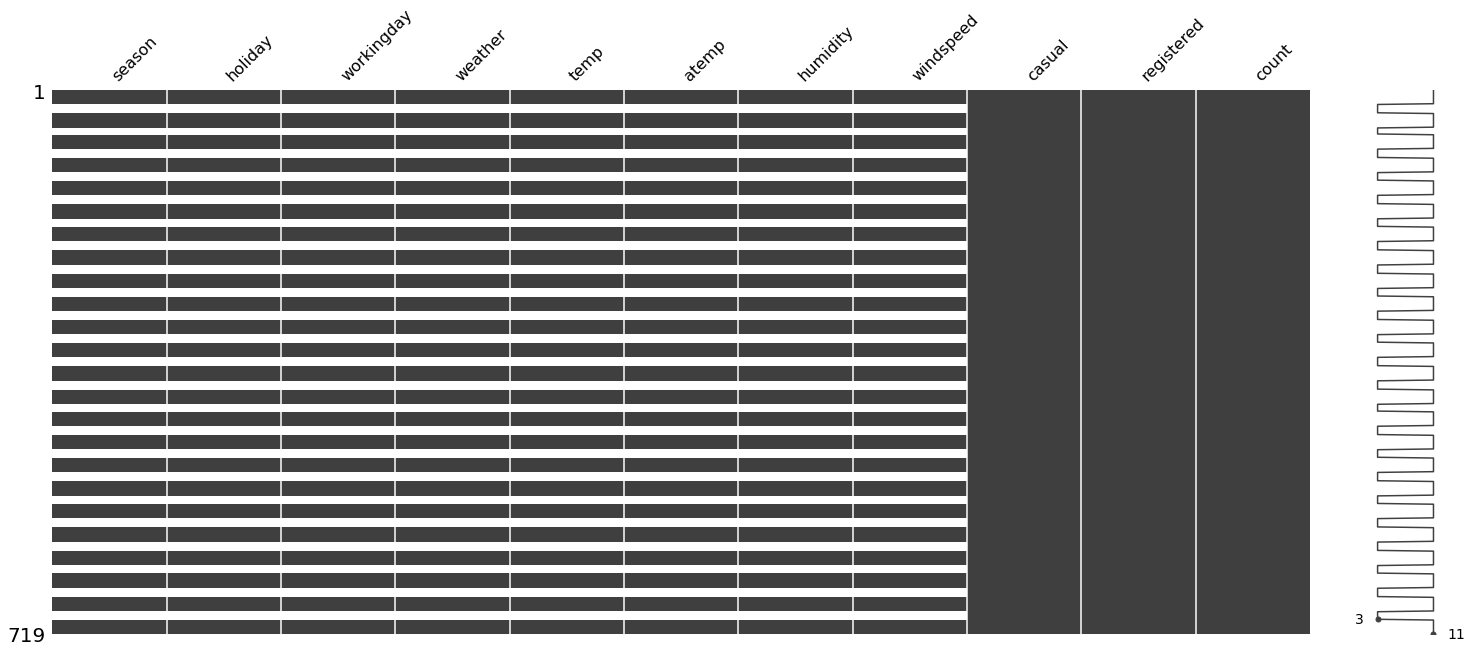

In [49]:
df_yulu_daily.isna().sum()
msno.matrix(df_yulu_daily)

In [52]:
df_yulu_daily = df_yulu_daily.replace('NaN', np.NaN)
df_yulu_daily.dropna(axis=0, how='any', thresh=None, subset=None, inplace = True)
df_yulu_daily.isna().sum()


season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Data Visualization

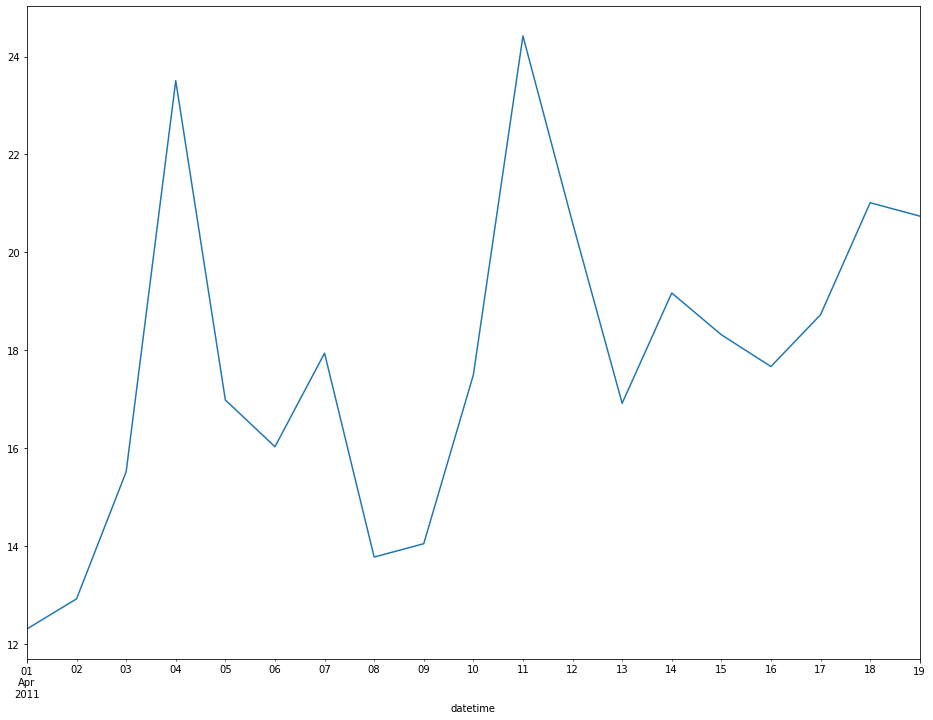

In [54]:
df_yulu_daily['2011-4']['temp'].head(30).plot()
plt.show()


The temperature and real feel ttemperature breakdown by seasons, shows what we would expect. An almost perfect correlation between the measured temperature and the real feel, also observable the seasonal changes.

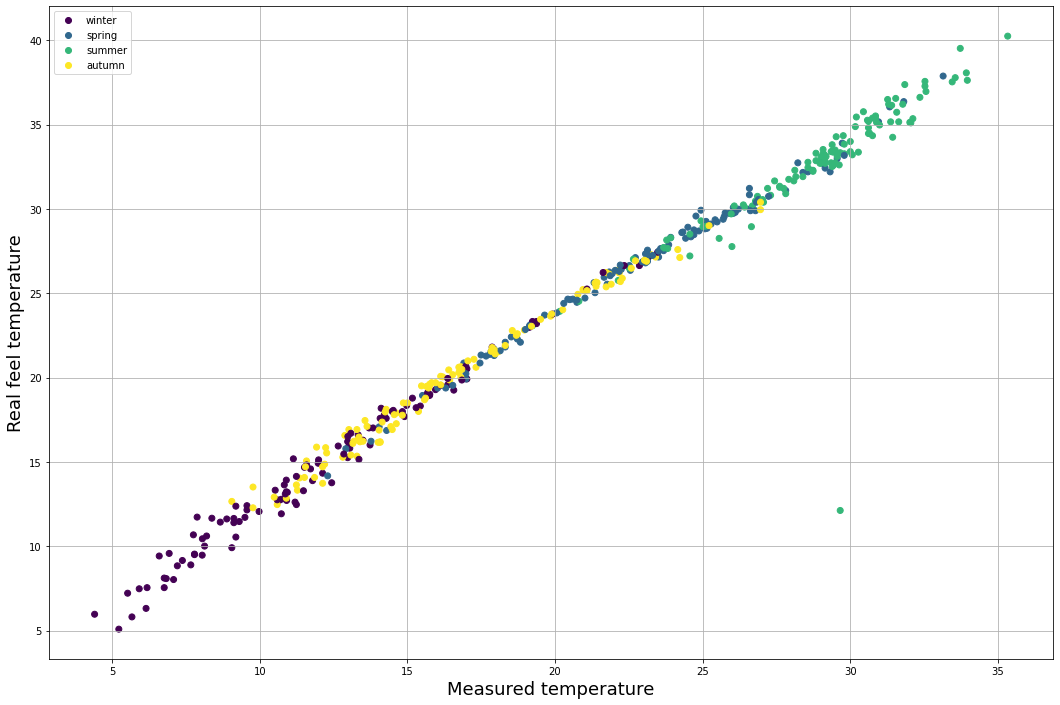

In [55]:
fig = plt.figure(figsize=(18, 12))
text_labels = ['winter', 'spring', 'summer', 'autumn']
plot = plt.scatter(x = df_yulu_daily['temp'], y = df_yulu_daily['atemp'], c = df_yulu_daily['season'])
plt.xlabel('Measured temperature', fontsize = 18)
plt.ylabel('Real feel temperature', fontsize = 18)
plt.legend(plot.legend_elements()[0], text_labels)
plt.grid()

The distribution of the four weather related variables.

Text(0.5, 1.0, 'Humidity distribution')

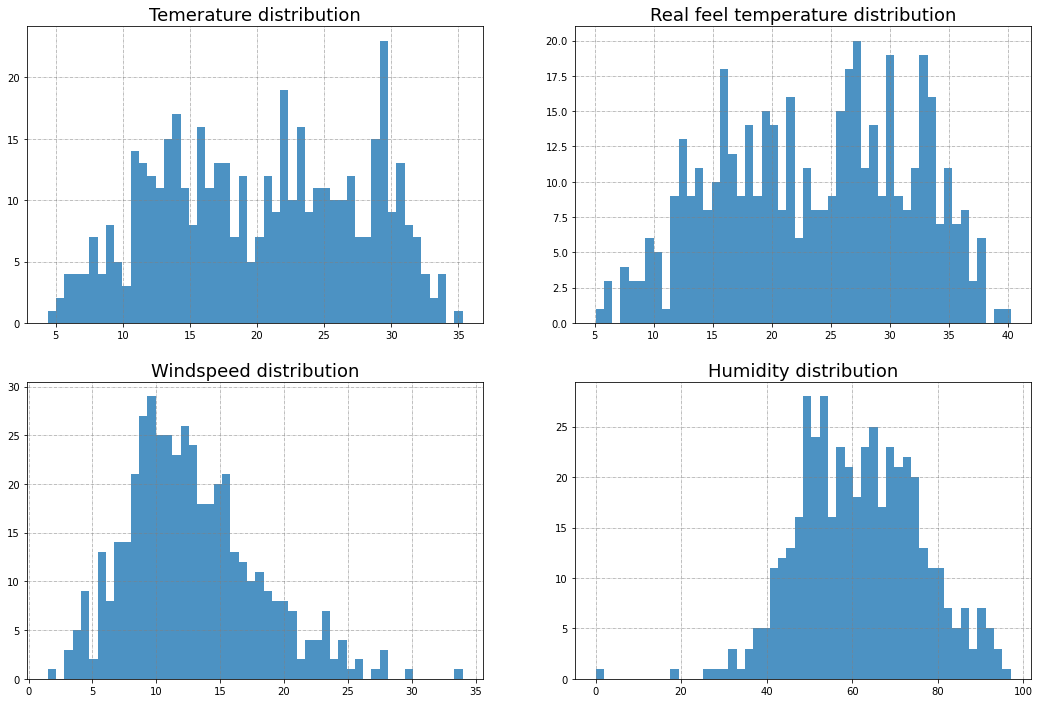

In [83]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 12))

ax1.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5)
ax2.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5)
ax3.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5)
ax4.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5)

ax1.hist(df_yulu_daily['temp'], bins = 50, alpha = 0.8)
ax2.hist(df_yulu_daily['atemp'], bins = 50, alpha = 0.8)
ax3.hist(df_yulu_daily['windspeed'], bins = 50, alpha = 0.8)
ax4.hist(df_yulu_daily['humidity'], bins = 50, alpha = 0.8)
ax1.set_title('Temerature distribution', fontsize = 18)
ax2.set_title('Real feel temperature distribution', fontsize = 18)
ax3.set_title('Windspeed distribution', fontsize = 18)
ax4.set_title('Humidity distribution', fontsize = 18)

Shown below the time series for the four weather observations.

Text(0.5, 1.0, 'Real feel temperature Time Series')

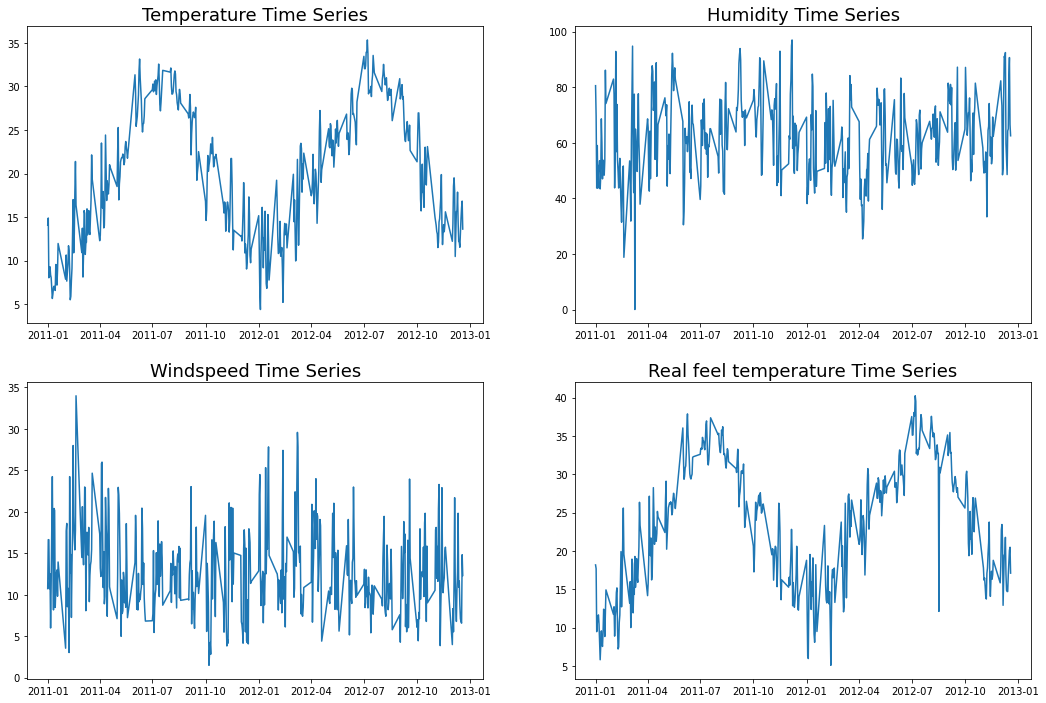

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (18,12))
ax1.plot(df_yulu_daily.index, df_yulu_daily['temp'])
ax2.plot(df_yulu_daily.index, df_yulu_daily['humidity'])
ax3.plot(df_yulu_daily.index, df_yulu_daily['windspeed'])
ax4.plot(df_yulu_daily.index, df_yulu_daily['atemp'])
ax1.set_title('Temperature Time Series', fontsize = 18)
ax2.set_title('Humidity Time Series', fontsize = 18)
ax3.set_title('Windspeed Time Series', fontsize = 18)
ax4.set_title('Real feel temperature Time Series', fontsize = 18)

The registered and casual users in the different seasons.

<function matplotlib.pyplot.show(close=None, block=None)>

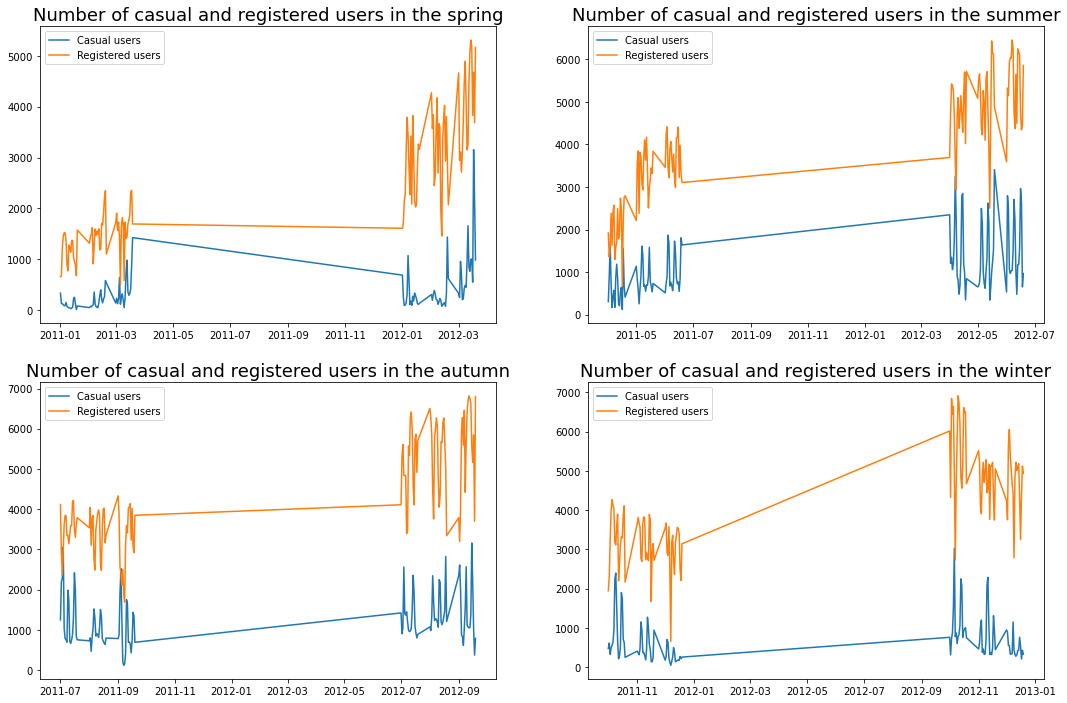

In [28]:
user_casual_spring = df_yulu_daily.loc[(df_yulu_daily['season'] == 1)]
user_casual_summer = df_yulu_daily.loc[(df_yulu_daily['season'] == 2)]
user_casual_autumn = df_yulu_daily.loc[(df_yulu_daily['season'] == 3)]
user_casual_winter = df_yulu_daily.loc[(df_yulu_daily['season'] == 4)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (18,12))

ax1.plot(user_casual_spring.index, user_casual_spring['casual'], label = 'Casual users')
ax2.plot(user_casual_summer.index, user_casual_summer['casual'], label = 'Casual users')
ax3.plot(user_casual_autumn.index, user_casual_autumn['casual'], label = 'Casual users')
ax4.plot(user_casual_winter.index, user_casual_winter['casual'], label = 'Casual users')
ax1.plot(user_casual_spring.index, user_casual_spring['registered'], label = 'Registered users')
ax2.plot(user_casual_summer.index, user_casual_summer['registered'], label = 'Registered users')
ax3.plot(user_casual_autumn.index, user_casual_autumn['registered'], label = 'Registered users')
ax4.plot(user_casual_winter.index, user_casual_winter['registered'], label = 'Registered users')
ax1.set_title('Number of casual and registered users in the spring', fontsize = 18)
ax2.set_title('Number of casual and registered users in the summer', fontsize = 18)
ax3.set_title('Number of casual and registered users in the autumn', fontsize = 18)
ax4.set_title('Number of casual and registered users in the winter', fontsize = 18)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

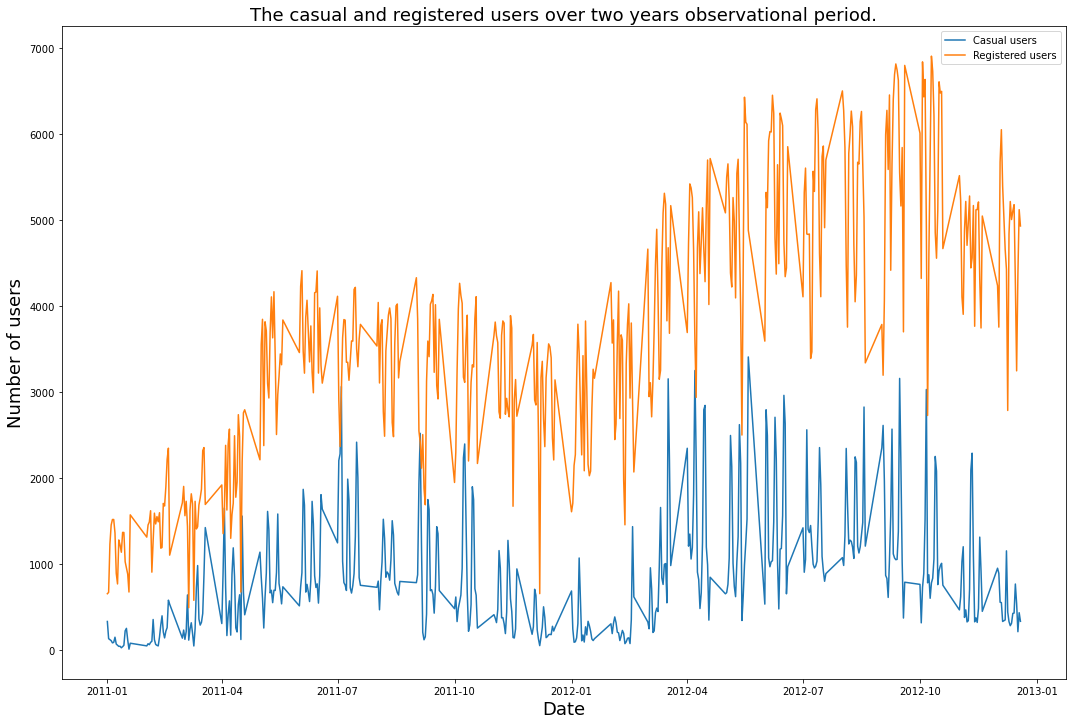

In [29]:
plt.figure(figsize=(18,12))
plt.plot(df_yulu_daily.index, df_yulu_daily['casual'], label = 'Casual users')
plt.plot(df_yulu_daily.index, df_yulu_daily['registered'], label = 'Registered users')
plt.title('The casual and registered users over two years observational period.', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Number of users', fontsize = 18)
plt.legend()
plt.show

In [30]:
list = ['temp', 'atemp', 'windspeed', 'humidity']
for i in list:   
    stat, p = shapiro(df_yulu_daily[i])
    print(i + ': stat=%.3f, p=%.3f' % (stat, p) + ' using Shapiro-Wilk test')

    stat, p = normaltest(df_yulu_daily[i])
    print(i + ': stat=%.3f, p=%.3f' % (stat, p) + " using D'Agistino test")

temp: stat=0.968, p=0.000 using Shapiro-Wilk test
temp: stat=140.367, p=0.000 using D'Agistino test
atemp: stat=0.974, p=0.000 using Shapiro-Wilk test
atemp: stat=79.611, p=0.000 using D'Agistino test
windspeed: stat=0.972, p=0.000 using Shapiro-Wilk test
windspeed: stat=37.051, p=0.000 using D'Agistino test
humidity: stat=0.991, p=0.009 using Shapiro-Wilk test
humidity: stat=1.820, p=0.403 using D'Agistino test
